In [ ]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

Downloading...
From (original): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
From (redirected): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM&confirm=t&uuid=4c0abfbc-ee03-40a7-9e9a-429953f35579
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:02<00:00, 20.5MB/s]


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.1/107.7 GB disk)


In [ ]:
import os
import shutil
import yaml
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

In [ ]:
def extract_data_from_xml(root_dir):
    """
    Trích xuất dữ liệu từ file words.xml trong bộ IC03

    Hàm này dùng để trích các thông tin từ file .xml bao gồm:
    image paths, image sizes, image labels và bboxes

    Parameters:
        root_dir (str): Đường dẫn đến thư mục root của dataset

    Returns:
        tuple: Chứa 4 lists lần lượt là: image paths, image sizes, image labels, và bboxes.
    """

    # Tạo path đến file words.xml
    xml_path = os.path.join(root_dir, 'words.xml')
    # Parse file xml
    tree = ET.parse(xml_path)
    # Đọc thẻ root của file
    root = tree.getroot()

    # Khai báo các list rỗng để lưu dữ liệu
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    # Duyệt qua từng thẻ ảnh <image>
    for img in root:
        # Khai báo các list rỗng chứa bboxes và labels của ảnh đang xét
        bbs_of_img = []
        labels_of_img = []

        # Duyệt qua từng thẻ boundingbox
        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # Bỏ qua trường hợp label không phải kí tự alphabet hoặc number
                if not bb[0].text.isalnum():
                    continue

                # Bỏ qua trường hợp label là chữ 'é' hoặc ñ'
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                # Đưa thông tin tọa độ bbox vào list bbs_of_img
                # Format bbox: (xmin, ymin, bbox_width, bbox_height)
                bbs_of_img.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height'])
                    ]
                )
                # Đưa label vào list labels_of_img (đã chuyển chữ viết thường)
                labels_of_img.append(bb[0].text.lower())

        # Đưa thông tin path ảnh đang xét vào list img_paths
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        # Đưa thông tin độ phân giải ảnh vào list img_sizes
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        # Đưa list bbox vào list bboxes
        bboxes.append(bbs_of_img)
        # Đưa list labels vào list img_labels
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [ ]:
# Thực hiện lời gọi hàm extract_data_from_xml()
dataset_dir = 'drive/MyDrive/datasets/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [ ]:
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    """
    Thực hiện normalize bounding box

    Parameters:
        image_paths (list): Danh sách chứa các path ảnh.
        image_sizes (list): Danh sách chứa độ phân giải ảnh.
        bounding_boxes (list): Danh sách chứa danh sách bounding box.

    Returns:
        yolov8_data (list): Danh sách gồm (image_path, image_size, bboxes)
    """
    # Khai báo list rỗng để chứa kết quả
    yolov8_data = []

    # Duyệt qua từng bộ path, resolution và bboxes ảnh.
    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        # Khai báo list rỗng để chứa label (format mới)
        yolov8_labels = []

        # Duyệt qua từng bbox
        for bbox in bboxes:
            x, y, w, h = bbox

            # Thực hiện normalize bbox
            # Format bbox hiện tại: (x_min, y_min, width, height)
            # Format bbox của yolo: (x_center, y_center, width, height)
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Mã class, mặc định = 0 vì chỉ có 1 class 'text'
            class_id = 0

            # Đổi format label
            # Format: "class_id x_center y_center width height"
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data

In [ ]:
# Định nghĩa class
class_labels = ['text']

# Thực hiện lời gọi hàm
yolov8_data = convert_to_yolov8_format(
    img_paths,
    img_sizes,
    bboxes
)

In [ ]:
yolov8_data

[('drive/MyDrive/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
  ['0 0.194375 0.40791666666666665 0.17125 0.1625',
   '0 0.5321875 0.40208333333333335 0.424375 0.1525',
   '0 0.309375 0.5825 0.38875 0.145',
   '0 0.67875 0.5770833333333333 0.27875 0.15583333333333332',
   '0 0.0746875 0.04125 0.059375 0.0725',
   '0 0.2159375 0.03833333333333333 0.123125 0.07333333333333333',
   '0 0.5309375 0.03375 0.071875 0.0675',
   '0 0.19625 0.7645833333333333 0.1425 0.11583333333333333',
   '0 0.3471875 0.7770833333333333 0.103125 0.09083333333333334',
   '0 0.4496875 0.7758333333333334 0.044375 0.08833333333333333',
   '0 0.571875 0.7620833333333333 0.13625 0.1175']),
 ('drive/MyDrive/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG',
  ['0 0.5346875 0.6008333333333333 0.529375 0.14333333333333334']),
 ('drive/MyDrive/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG',
  ['0 0.566875 0.21875 0.31375 0.0675',
   '0 0.56 0.22375 0.3375 0.025833333333333333',
   '0 0.57093

In [ ]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolov8_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [ ]:
def save_data(data, src_img_dir, save_dir):
    """
    Xây dựng thư mục chứa dữ liệu theo format YOLO

    Parameters:
        data (list): Danh sách chứa thông tin label ảnh.
        src_img_dir (str): Path đến thư mục dữ liệu gốc.
        save_dir (str): Path đến thư mục dữ liệu mới.
    """
    # Tạo thư mục dữ liệu mới nếu chưa có
    os.makedirs(save_dir, exist_ok=True)

    # Tạo thư mục 'images' và 'labels'
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    # Duyệt qua từng bộ path, bbox, label ảnh
    for image_path, yolov8_labels in data:
        # Copy ảnh từ thư mục gốc sang thư mục 'images'
        src_img_dir = ""
        shutil.copy(
            os.path.join(src_img_dir, image_path),
            os.path.join(save_dir, 'images')
        )
        print(src_img_dir)

        # Ghi nội dung label vào file image_name.txt ở thư mục 'labels'
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")


In [ ]:
# Thực hiện lời gọi hàm cho 3 set train, val, test
save_yolo_data_dir = 'datasets/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(
    save_yolo_data_dir,
    'train'
)
save_val_dir = os.path.join(
    save_yolo_data_dir,
    'val'
)
save_test_dir = os.path.join(
    save_yolo_data_dir,
    'test'
)

save_data(
    train_data,
    dataset_dir,
    save_train_dir
)
save_data(
    test_data,
    dataset_dir,
    save_val_dir
)
save_data(
    val_data,
    dataset_dir,
    save_test_dir
)

In [ ]:
data_yaml = {
    'path': 'yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s.yaml').load('yolov8s.pt')

# Train the model
epochs = 100
imgsz = 1024
results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    imgsz=imgsz,
    project='models',
    name='yolov8/detect/train'
)

Transferred 355/355 items from pretrained weights


NameError: name 'yolo_yaml_path' is not defined

In [ ]:
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project='models',
    name='yolov8/detect/val'
)

FileNotFoundError: [Errno 2] No such file or directory: 'models/yolov8/detect/train/weights/best.pt'

In [ ]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!ls SceneTrialTrain/apanar_06.08.2002

IMG_1247.JPG  IMG_1263.JPG  IMG_1284.JPG  IMG_1291.JPG	IMG_1300.JPG  IMG_1306.JPG  IMG_1315.JPG
IMG_1252.JPG  IMG_1265.JPG  IMG_1285.JPG  IMG_1292.JPG	IMG_1301.JPG  IMG_1307.JPG  IMG_1316.JPG
IMG_1253.JPG  IMG_1269.JPG  IMG_1286.JPG  IMG_1293.JPG	IMG_1302.JPG  IMG_1308.JPG  IMG_1317.JPG
IMG_1255.JPG  IMG_1281.JPG  IMG_1288.JPG  IMG_1294.JPG	IMG_1303.JPG  IMG_1311.JPG
IMG_1259.JPG  IMG_1282.JPG  IMG_1289.JPG  IMG_1298.JPG	IMG_1304.JPG  IMG_1312.JPG
IMG_1261.JPG  IMG_1283.JPG  IMG_1290.JPG  IMG_1299.JPG	Img_1305.jpg  Img_1313.jpg


{'name': 'text', 'class': 0, 'confidence': 0.95342, 'box': {'x1': 865.10693, 'y1': 599.40259, 'x2': 1310.37488, 'y2': 785.15778}}


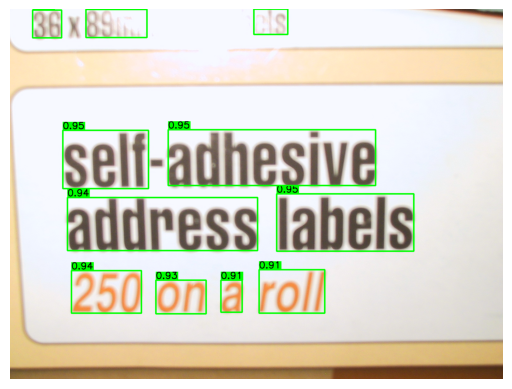

In [ ]:
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train/weights/best.pt'
img_path = 'SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG'
conf_thres=0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].tojson())
print(predictions[0])
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()